# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
#import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
### Content Analysis of Personification of Alexa based on Amazon Reviews

* For my final project, I will analyze consumers' reviews about Alexa, the most prevalent conversational agents in the current age, to see how people view about it and to what extent mass consumers would personify Alexa. The specific features I am interested to inspect through Amazon reviews are: 1) 'personification' or 'humanlikenss', 2) perception of 'socail capabilities' of Alexa, and 3) consumers' general emotional feelings and attitudes towards it. Moreover, I am also interested in how these features  of interests are related with consumers' general satisfaction towards Alexa (rating scores) and what factors might influence these features, for example, whether the consumer is a tech-head, or the consumer uses Alexa in a family settings or not, and what functions they use with it, will influence people's 'personificaiton' perception of Alexa. 

## ***Why?***
* Currently, with the development of artificial intelligence, conversational agent (CA) is entering into our daily life and becomes one of the most approachable 'AI creature' in normal life, among which, Alexa (Amazon echo), is the most prevalent one. However, how people view this 'intelligent creature' in dail life-to what extent they are intelligent and social capable,is still uncertain and of great interest, since the 'humanlikeness' and 'social capability' perceived by mass consumers could impact or increase their satisfaction and further use of it and general CAs. The investigation of 'personification' of Alexa is of interests both practically, for further CA design, and theoretically, for deeper understandings of human perception of intelligent agents.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

* For this project, I will mainly use reviews on Amazon echo webpages, because it is the most available feedback of mass consumers about Alexa. Sampling from these written reviews, I hope to infer the general experiences and feelings of mass users about Alexa.One possible limitation of this sample is that Amazon might present the reviews positively biased in its website, especially those in front. Therefore, to minimize bias to the most extent, I will scrape all the reviews on Amazon echo webpage and then sample accordingly or even directly analyze it. Another unavoidable limitation with this sample is the 'self-selection' bias that it only covers people who would like to respond and give a feedback and might overlook the voices fomr the 'quiet' ones. 

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [2]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [3]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [4]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [5]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [6]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: Scott's $\pi$, Cohen's $\kappa$, and Krippendorff's $\alpha$ which each measure the extent of agreement between two annotators, but take into account the possibility of the agreement occurring by chance in slightly different ways. Any agreement measure begins with the frequency of codes:

In [7]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider the "confusion matrix" or matrix of coded agreements between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


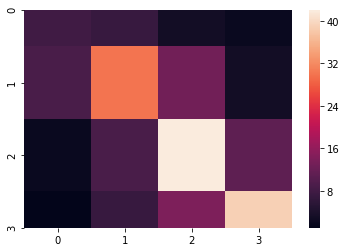

In [9]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Scott's $\pi$ is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where Pr($a$) is relative observed agreement, and Pr($e$) is expected agreement using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [10]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The generalization of Scott's $\pi$ to $n$ coders is Fleiss' $\kappa$ (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [11]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

Krippendorff's $\alpha$ generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding a weight matrix in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When produced with no arguments, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [12]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, Cohen's $\kappa$ also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is the relative observed agreement among raters, and $p_e$ is the hypothetical probability of chance agreement, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $. Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [13]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

In [14]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


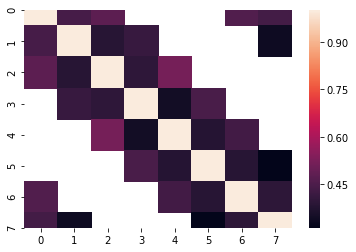

In [15]:
ax = seaborn.heatmap(m)
plt.show()

You can see that this 8 by 3 loop design will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [16]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and her considered metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [16]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [17]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather the correlation of values (Pearson's $\rho$) or correlation of ranks (Spearman's $\rho$) for pairs of coders:

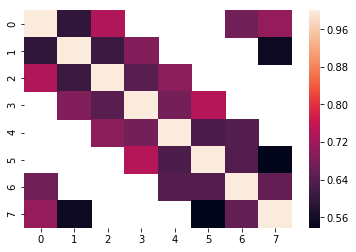

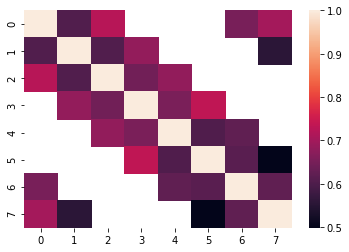

In [18]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [19]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

* In this section, I randomly selected 10 consumer reviews of Alexa and asked people to assess to what extent (5 point Likert Scale) the consumer perceived 'humanlikeness'and 'feelings'towards Alexa, based on the review the consumer wrote, in MTurk platform. In total, I received feedback from 13 annotators. Each one assessed all the 10 reviews.

In [87]:
# load the humanlikness annotation data
x_humanlikeness = np.loadtxt("Alexa_an_humanlikeness.txt")
anno_human = AnnotationsContainer.from_array(x_humanlikeness, missing_values=[-1])
anno_human.annotations# load the humanlikness annotation data
x_humanlikeness = np.loadtxt("Alexa_an_humanlikeness.txt")
anno_human = AnnotationsContainer.from_array(x_humanlikeness, missing_values=[-1])
anno_human.annotations

array([[1, 2, 3, 2, 2, 1, 2, 2, 2, 3, 2, 4, 1],
       [1, 2, 2, 2, 3, 1, 2, 2, 1, 2, 2, 2, 2],
       [1, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3],
       [2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 4, 1],
       [4, 1, 3, 3, 2, 4, 2, 1, 3, 3, 3, 2, 4],
       [3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3],
       [2, 1, 1, 3, 2, 2, 3, 1, 1, 1, 3, 2, 0],
       [1, 1, 2, 0, 3, 1, 2, 1, 2, 2, 0, 3, 0],
       [3, 4, 4, 4, 3, 3, 2, 4, 4, 4, 4, 2, 3],
       [1, 1, 1, 0, 3, 1, 1, 1, 2, 1, 0, 4, 1]])

In [88]:
anno_human.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

In [91]:
#frequency of each label for humanlikeness
pyanno.measures.agreement.labels_frequency(anno_human.annotations,5)

array([0.04615385, 0.26153846, 0.30769231, 0.28461538, 0.1       ])

In [89]:
# load the positiveness annotation data
x_positiveness = np.loadtxt("Alexa_an_positiveness.txt")
anno_pos = AnnotationsContainer.from_array(x_positiveness, missing_values=[-1])
anno_pos.annotations

array([[2, 3, 4, 1, 2, 2, 3, 3, 3, 4, 1, 3, 1],
       [3, 4, 4, 4, 3, 3, 2, 4, 4, 4, 4, 3, 4],
       [2, 4, 4, 4, 2, 2, 2, 4, 3, 4, 4, 2, 3],
       [2, 1, 3, 4, 2, 2, 2, 1, 4, 3, 4, 3, 3],
       [3, 2, 4, 3, 1, 3, 2, 2, 3, 4, 3, 2, 1],
       [4, 4, 3, 4, 2, 4, 2, 4, 4, 3, 4, 3, 4],
       [1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 3, 0],
       [4, 4, 3, 4, 2, 4, 2, 4, 4, 3, 4, 3, 4],
       [3, 4, 4, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4],
       [2, 2, 2, 2, 3, 2, 1, 2, 4, 2, 2, 4, 2]])

In [90]:
anno_pos.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

In [93]:
#frequency of each label for humanlikeness
frequency_label=pyanno.measures.agreement.labels_frequency(anno_human.annotations,5)
print(frequency_label)
ex_frequency_label=0
for i,a in enumerate(frequency_label):
    ex_frequency_label+=i*a
    
print('Humanlikenss average_score:',round(ex_frequency_label,2))

[0.04615385 0.26153846 0.30769231 0.28461538 0.1       ]
Humanlikenss average_score: 2.13


Ratings of 'humanlikenss' is central around score-3, average score is 2.13, indicating generally lower level of 'humanlikeness'; while the mode of 'positiveness' is score-5, average score is 2.82, indicating more positive feelings towards Alexa in general.

In [94]:
#frequency of each label for positiveness
frequency_label=pyanno.measures.agreement.labels_frequency(anno_pos.annotations,5)
print(frequency_label)
ex_frequency_label=0
for i,a in enumerate(frequency_label):
    ex_frequency_label+=i*a
    
print('Positiveness average_score:',round(ex_frequency_label,2))

[0.01538462 0.13076923 0.23846154 0.25384615 0.36153846]
Positiveness average_score: 2.82


Using the "confusion matrix" to assess the coded agreements between any two coders (transformed to frequency, considering the small sample size):

[[0.  0.  0.  0.  0. ]
 [0.  0.2 0.2 0.1 0. ]
 [0.  0.2 0.  0.  0. ]
 [0.  0.  0.  0.1 0.1]
 [0.  0.1 0.  0.  0. ]]


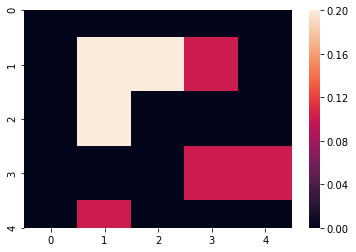

In [96]:
#for humanlikeness, coder 1-coder2
c = pyanno.measures.agreement.confusion_matrix(anno_human.annotations[:,0], anno_human.annotations[:,1],5)/(x_humanlikeness.shape[0])
print(c)
ac = seaborn.heatmap(c)
plt.show()

[[0.  0.  0.  0.  0. ]
 [0.  0.1 0.  0.  0. ]
 [0.  0.1 0.1 0.1 0.1]
 [0.  0.  0.1 0.  0.2]
 [0.  0.  0.  0.  0.2]]


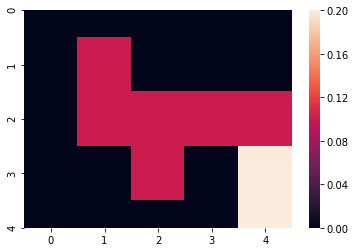

In [98]:
#for positiveness, coder 1-coder2
c = pyanno.measures.agreement.confusion_matrix(anno_pos.annotations[:,0], anno_pos.annotations[:,1],5)/(x_positiveness.shape[0])
print(c)
ac = seaborn.heatmap(c)
plt.show()

In [107]:
#for humanlikeness, scotts pi and cohen's kappa between coder1-2
print('scoots_pi:',scotts_pi(anno_human.annotations[:,0], anno_human.annotations[:,1]))
print('cohens_kappa:',cohens_kappa(anno_human.annotations[:,0], anno_human.annotations[:,1]))

scoots_pi: -0.06060606060606067
cohens_kappa: -0.06060606060606067


In [108]:
#for positiveness, scotts pi between coder1-2
print('scoots_pi:',scotts_pi(anno_pos.annotations[:,0], anno_pos.annotations[:,1]))
print('cohens_kappa:',cohens_kappa(anno_pos.annotations[:,0], anno_pos.annotations[:,1]))

scoots_pi: 0.17241379310344834
cohens_kappa: 0.2207792207792208


To evaluate the extent of agreement among all coders, using fleiss K,averaged cohens kappa score and Pearson and Spearman correlations. From the results below, we could see that the level of inter-coder reliability is really low. The fleiss K and cohens kappa scores are only around 0.15. The reasons might be two folds: 1) assessing reviews about Alexa is a relative subjective judgement which renders lower consistency among coders; 2) coders on MTurk platform provided low quality coding. 

In [123]:
#for humanlikeness, fleiss K and cohen's kappa among all coders
print('Humanlikeness')
print('fleiss_K:',fleiss_kappa(anno_human.annotations[::]))
print('Cohens kappa',pairwise_metric_average(cohens_kappa, anno_human.annotations))
print('')
print('Pearson rho',pairwise_metric_average(pearsons_rho, anno_human.annotations))
print('Spearmans rho',pairwise_metric_average(spearmans_rho, anno_human.annotations))

Humanlikeness
fleiss_K: 0.15539644656589763
Cohens kappa 0.16023958156644788

Pearson rho 0.2924858593827073
Spearmans rho 0.2710945711579738


In [124]:
#for positiveness, fleiss K among all coders
print('fleiss_K:',fleiss_kappa(anno_pos.annotations[::]))
print('Cohens kappa',pairwise_metric_average(cohens_kappa, anno_pos.annotations))
print('')
print('Pearson rho',pairwise_metric_average(pearsons_rho, anno_pos.annotations))
print('Spearmans rho',pairwise_metric_average(spearmans_rho, anno_pos.annotations))

fleiss_K: 0.13494762984558908
Cohens kappa 0.1663377534053132

Pearson rho 0.4403807900470053
Spearmans rho 0.3914054041037557


In [109]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    

For a detailed inspection of agreement among coders, I drew the averaged cohens kappa metrix across all coder pairs. As the results below shown: coder 5 performed extremely unrelated with the other coders (even negative with many other coders); also coder 1, 6, 7 and 12's performance had relative low relevance with the others.These coders presumably were 'Troll's. 

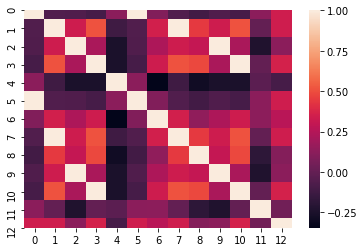

In [114]:
#for humanlikeness, averaged cohens kappa across coder pairs
m = pairwise_matrix(cohens_kappa, anno_human.annotations)
ax = seaborn.heatmap(m)
plt.show()

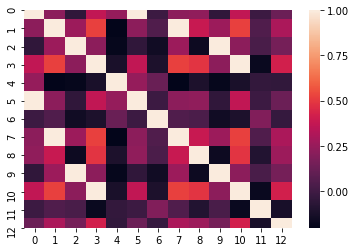

In [115]:
#for positiveness, averaged cohens kappa across coder pairs
m = pairwise_matrix(cohens_kappa, anno_pos.annotations)
ax = seaborn.heatmap(m)
plt.show()

Therefore, to preliminarily examining the effects of these 'suspected troll' coders, I exclude these coders and recalculate fleiss K and averaged cohen's kappa scores, as shown below: the inter-coder reliability scores increase greatly, to a moderate level (0.36~0.40), after exclusion these potential trolls. 

In [126]:
#for humanlikeness, fleiss K and cohen's kappa excluding 1,5,6,7,12  (0,4,5,6,11)
anno_human_select=[1,2,3,7,8,9,10,12]
print('fleiss_K:',fleiss_kappa(anno_human.annotations[:,anno_human_select]))
print('Cohens kappa',pairwise_metric_average(cohens_kappa, anno_human.annotations[:,anno_human_select]))
print('')
print('Pearson rho',pairwise_metric_average(pearsons_rho, anno_human.annotations[:,anno_human_select]))
print('Spearmans rho',pairwise_metric_average(spearmans_rho, anno_human.annotations[:,anno_human_select]))

fleiss_K: 0.40023612750885484
Cohens kappa 0.4105111794800956

Pearson rho 0.678669413705095
Spearmans rho 0.6546538593398983


In [127]:
#for positiveness, fleiss K and cohen's kappa excluding 1,5,6,7,12  (0,4,5,6,11)
anno_human_select=[1,2,3,7,8,9,10,12]
print('fleiss_K:',fleiss_kappa(anno_pos.annotations[:,anno_human_select]))
print('Cohens kappa',pairwise_metric_average(cohens_kappa, anno_pos.annotations[:,anno_human_select]))
print('')
print('Pearson rho',pairwise_metric_average(pearsons_rho, anno_pos.annotations[:,anno_human_select]))
print('Spearmans rho',pairwise_metric_average(spearmans_rho, anno_pos.annotations[:,anno_human_select]))

fleiss_K: 0.368131868131868
Cohens kappa 0.37408092023369593

Pearson rho 0.6297313199229181
Spearmans rho 0.5447014765954651


* Overall, from the analysis above, we could see that the inter-coders reliability of the original 13 coders is really low (around 0.15 for Cohen's kappa). 'Suspected Trolls' played a big part in driving this score low,verified from both the visualization and from cohen's kappa scores calculated excluded these 'suspected trolls'. However, more reliable analysis and modeling should be done to better identify these unreliable coders. 


* Regarding the 'suspected' bad coders, its percentage is really high relative to the whole number of coders. It might be reasonable since the coders come from an anonymous crowdsourcing platform, who did this task mainly for monetary compensation. It is a nature of MTurk. Moreover, even though I have set check questions in the short survey, I only screened 2 of the 5 suspected bad coders. Maybe that is why we should pay enough efforts in distinguishing them (Section 2).

# Models

However, what if some coders are better than others. The prior measures all rely on the assumption that all coders are equally good. What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. Model A can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. Model B with $\theta$s models the relationship between each coder and code. Model B is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [36]:
# create a new instance of model A, with 4 label classes
model = ModelB.create_initial_state(4, 8)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[0.60660037 0.24678604 0.12645366 0.02015993]
  [0.13079129 0.67826983 0.1233115  0.06762738]
  [0.08976607 0.07115571 0.76238219 0.07669602]
  [0.02815263 0.11363628 0.221096   0.6371151 ]]

 [[0.66620975 0.25875549 0.02747766 0.0475571 ]
  [0.09446106 0.64070892 0.2417843  0.02304573]
  [0.12097178 0.21577157 0.63398727 0.02926939]
  [0.01147081 0.05697741 0.12363607 0.80791571]]

 [[0.65975263 0.18069718 0.0125044  0.14704579]
  [0.02230801 0.7303055  0.1806224  0.06676408]
  [0.18850505 0.18380751 0.43736444 0.190323  ]
  [0.01677235 0.1177432  0.09119806 0.77428639]]

 [[0.68331752 0.10692937 0.06027286 0.14948025]
  [0.20721201 0.62131427 0.05156379 0.11990992]
  [0.08857543 0.1214393  0.63993881 0.15004646]
  [0.06537441 0.08246091 0.10010582 0.75205886]]

 [[0.70373154 0.20604907 0.07851716 0.01170224]
  [0.24795499 0.69231156 0.03567237 0.02406108]
  [0.14359495 0.14381736 0.578902   0.1336857 ]
  [0.02115415 0.0825623  0.09171147 0.80457209]]

 [[0.58079781 0.26812415 0.135

In [37]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [39]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

In [40]:
model = ModelB.create_initial_state(4, 8)
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate the posterior distribution over the true label classes.

In [41]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [44]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

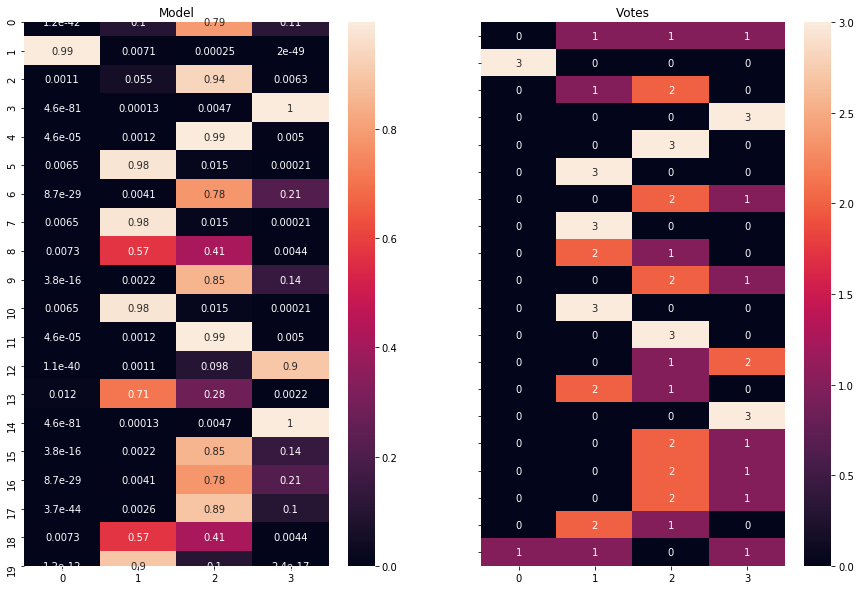

In [46]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [47]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [48]:
print(samples[0].mean(axis=0))
print(samples[0].std(axis=0))

[[[0.7260973  0.20511645 0.04841893 0.02036733]
  [0.13919245 0.69688181 0.09481662 0.06910912]
  [0.02971233 0.14877245 0.68158512 0.13993011]
  [0.01125747 0.0310274  0.10299137 0.85472375]]

 [[0.67443054 0.20296332 0.09260797 0.02999817]
  [0.13575555 0.68412018 0.13113899 0.04898528]
  [0.03539265 0.16778944 0.65754458 0.13927333]
  [0.01128219 0.06505831 0.1342907  0.7893688 ]]

 [[0.78336879 0.14902856 0.04896136 0.01864129]
  [0.10102057 0.75929559 0.0981665  0.04151734]
  [0.06701731 0.13137037 0.69596227 0.10565005]
  [0.01349806 0.06197973 0.21472323 0.70979898]]

 [[0.65964495 0.26964217 0.05152334 0.01918954]
  [0.09994988 0.73448205 0.12098696 0.04458112]
  [0.02501431 0.15254587 0.66882715 0.15361268]
  [0.00830961 0.03815513 0.23606977 0.71746549]]

 [[0.76821926 0.13208716 0.07942408 0.02026949]
  [0.12029008 0.68295073 0.15065039 0.0461088 ]
  [0.01882956 0.21042735 0.63918813 0.13155496]
  [0.00839317 0.06885881 0.18797942 0.7347686 ]]

 [[0.72145719 0.22129743 0.043

Let's try everything again with ModelBt

In [49]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.78440401 0.88877923 0.73518464 0.82189805 0.86314596 0.70855672
 0.75413085 0.7388779 ]
-3299.62506010231


In [50]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[0.79128008 0.74081418 0.76238579 0.72540768 0.71651341 0.71854671
 0.77310444 0.71660493]
-2811.946642783718


In [51]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.0111023  0.2891832  0.36500048 0.33471402]
 [0.99023551 0.00241591 0.00404454 0.00330404]
 [0.00249945 0.05509871 0.93457326 0.00782857]
 ...
 [0.00252898 0.04393663 0.94561333 0.00792105]
 [0.00249401 0.00571177 0.93253665 0.05925758]
 [0.0318872  0.93883063 0.01611644 0.01316574]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

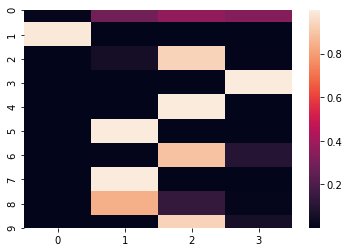

In [52]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity. For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [53]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[2, 2, 3],
       [1, 1, 2],
       [3, 3, 3],
       [3, 0, 0],
       [3, 3, 3],
       [3, 3, 3],
       [2, 0, 3],
       [2, 0, 1],
       [3, 3, 3],
       [2, 2, 2],
       [3, 3, 2],
       [2, 2, 2],
       [3, 1, 2],
       [3, 2, 1],
       [3, 3, 0],
       [3, 3, 1],
       [1, 1, 3],
       [0, 1, 0],
       [1, 0, 3],
       [3, 3, 3]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [54]:
model = ModelBt.create_initial_state(4, 8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

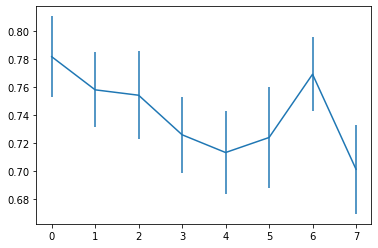

In [55]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

I performed a recent study in which the variables from thousands of articles were associated with those used in the General Social Survey, a widely used population sample, in order to interrogate how social science analyses are performed. Each article was reread and coded by a balanced set of three student coders using a 6 choose 3 design, such that all possible 3-coder-subsets (20) coded an equal number of articles. Coding was performed through a website that allowed students access to the digital article. To evaluate the validity of the student codes, we also recruited a sample of authors associated with 97 of our published articles to fill out the same online survey. 

Because not all coders coded items with equal accuracy, and because “don’t know” was an optional answer, leading to potential ties, we used a generative, probabilistic model to estimate the maximum a posteriori probability (MAP) prediction that an item’s code is true, which integrates over the estimated accuracy of coders, assuming only that the entire population of coders is slightly more often right than wrong. The model (“Model B”) is based on a simple underlying generation process that directly accounts for the probability that coded values are correct (Rzhetsky et al. 2009). For each coded value j, a set of parameters, denoted γj, represents the probability that each coded value is correct. For the ith coder (i = 1, 2, …, 6), we introduce a matrix of probabilities, denoted λ(i)x|y, that defines the probability that she assigns code x (e.g., Dependent variable) to a GSS variable with correct annotation y. For a perfect coder, the matrix λ(i)x|y would equal the identity matrix and her vote would count most toward the total. For a coder that always codes incorrectly—a “troll”—her matrix λ(i)x|y will have all its value off the diagonal and will only minimally influence the posterior. We co-authored the open source pyanno software that implements this model.

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [56]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="../data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [57]:
dev.shape

(21461, 6)

In [58]:
anno_dv.labels

[0, 1]

In [59]:
anno_dv.missing_values

[-1]

In [60]:
anno_dv.annotations.shape

(21461, 6)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [61]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[1.         0.62426874 0.46682841 0.44599604 0.16569888 0.36657805]
 [0.62426874 1.         0.53480937 0.52673854 0.3306905  0.59513211]
 [0.46682841 0.53480937 1.         0.50580068 0.42393752 0.49833997]
 [0.44599604 0.52673854 0.50580068 1.         0.46517493 0.47023754]
 [0.16569888 0.3306905  0.42393752 0.46517493 1.         0.66190749]
 [0.36657805 0.59513211 0.49833997 0.47023754 0.66190749 1.        ]]


Let's visualize that...

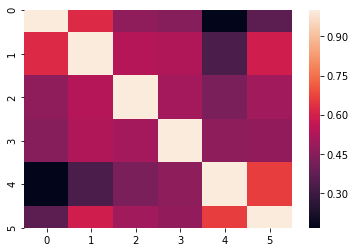

In [62]:
ax = seaborn.heatmap(m)
plt.show()

In [63]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [64]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

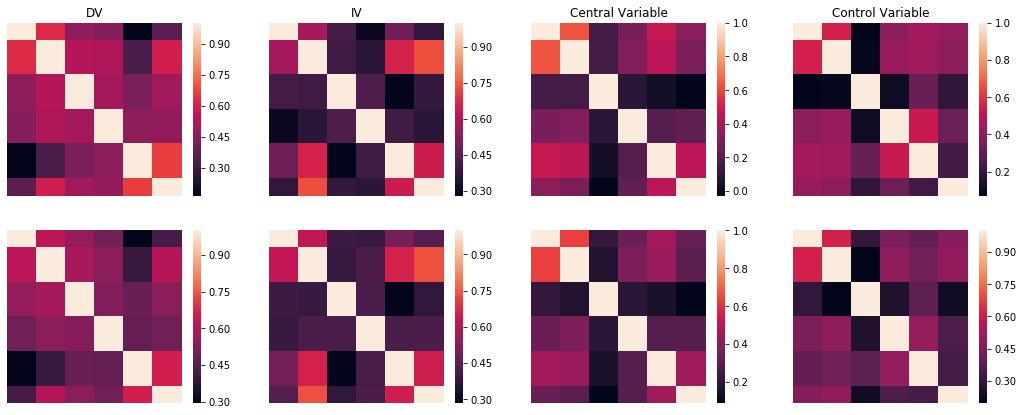

In [65]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [66]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [47]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.47214258445407015
0.5142407278222342
0.4529627823703711
0.47596526866863437
0.27082376869768193
0.3151404982836273
0.32833477875850064
0.39458527791963466


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [67]:
mergedata = np.loadtxt(fname="../data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [68]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [69]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Dependent variable -- kappa & rho
0.3744311057948666
0.3856343720362062

Independent variable
0.5430690164641346
0.5529974941771468

Central variable
-0.064017189548477
-0.08887644319259187

Control variable
0.2815172499181942
0.28239237574620263


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [70]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.4763912310286678
0.35834738617200673

Independent
0.23777403035413153
0.3136593591905565

Central
0.35328836424957843
0.7512647554806071

Control
0.081787521079258
0.09443507588532883


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [72]:
dev.shape

(21461, 6)

In [73]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [74]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([0.82837015, 0.77813102, 0.63340314, 0.91113454, 0.64660554,
       0.92339529, 0.90055693, 0.67770244])

In [75]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.55559497 0.44440503]
-30600.863399502276


In [76]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.69455487 0.30544513]
-25462.473635032595


In [77]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

[[0.0111023  0.2891832  0.36500048 0.33471402]
 [0.99023551 0.00241591 0.00404454 0.00330404]
 [0.00249945 0.05509871 0.93457326 0.00782857]
 ...
 [0.00252898 0.04393663 0.94561333 0.00792105]
 [0.00249401 0.00571177 0.93253665 0.05925758]
 [0.0318872  0.93883063 0.01611644 0.01316574]]


In [78]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [79]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)


Mean
[[[0.97916233 0.02083767]
  [0.5142257  0.4857743 ]]

 [[0.96931823 0.03068177]
  [0.26058307 0.73941693]]

 [[0.98276983 0.01723017]
  [0.34728319 0.65271681]]

 [[0.93542356 0.06457644]
  [0.2394559  0.7605441 ]]

 [[0.69273495 0.30726505]
  [0.0459715  0.9540285 ]]

 [[0.86426502 0.13573498]
  [0.06890138 0.93109862]]]

STD
[[[0.00231965 0.00231965]
  [0.01144977 0.01144977]]

 [[0.00310482 0.00310482]
  [0.01440237 0.01440237]]

 [[0.0032738  0.0032738 ]
  [0.01366678 0.01366678]]

 [[0.00476666 0.00476666]
  [0.0104721  0.0104721 ]]

 [[0.00738764 0.00738764]
  [0.00562103 0.00562103]]

 [[0.00614644 0.00614644]
  [0.0069255  0.0069255 ]]]


We will use Model B estimates for other variable assessments.

In [80]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print(model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print(model_testB.pi)
print(model_testB.log_likelihood(anno_test.annotations))
print(anno_test.annotations.shape)
posterior_testB = model_testB.infer_labels(anno_test.annotations)
print(posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print(ci_test_mean)

-113.44045866791839
[9.20933481e-20 1.00000000e+00]
-48.9756711393957
(48, 6)
(48, 2)
[[[0.78685559 0.21314441]
  [0.12872701 0.87127299]]

 [[0.80521855 0.19478145]
  [0.0863841  0.9136159 ]]

 [[0.79569198 0.20430802]
  [0.50695433 0.49304567]]

 [[0.79043697 0.20956303]
  [0.07032334 0.92967666]]

 [[0.80596918 0.19403082]
  [0.36161436 0.63838564]]

 [[0.78862947 0.21137053]
  [0.1299177  0.8700823 ]]]


In [82]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-36275.117778232176
[0.61093546 0.38906454]
-28620.66523246587
(21461, 6)
(21461, 2)
[[[0.97125291 0.02874709]
  [0.34695742 0.65304258]]

 [[0.93692977 0.06307023]
  [0.05341959 0.94658041]]

 [[0.65849953 0.34150047]
  [0.21018388 0.78981612]]

 [[0.53683521 0.46316479]
  [0.03039954 0.96960046]]

 [[0.87494448 0.12505552]
  [0.09830812 0.90169188]]

 [[0.8910806  0.1089194 ]
  [0.0899942  0.9100058 ]]]
-32708.72103585526
[0.23988844 0.76011156]
-25034.918555765576
(21461, 6)
(21461, 2)
[[[0.89398475 0.10601525]
  [0.06979539 0.93020461]]

 [[0.78602348 0.21397652]
  [0.05735376 0.94264624]]

 [[0.99273752 0.00726248]
  [0.84192326 0.15807674]]

 [[0.94989414 0.05010586]
  [0.45644605 0.54355395]]

 [[0.67675154 0.32324846]
  [0.05667911 0.94332089]]

 [[0.5916707  0.4083293 ]
  [0.09589991 0.90410009]]]
-42217.294786540995
[0.83068326 0.16931674]
-19415.702035242168
(21461, 6)
(21461, 2)
[[[0.97083486 0.02916514]
  [0.34655695 0.65344305]]

 [[0.937131   0.062869  ]
  [0.0520433  0.

Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [83]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [84]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) # posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [85]:
predicted_annotations.shape

(21461, 8)

These annotations allowed us to uncover the degree to which social scientists alter their models to achieve a better fit...undocumented data mining. The answer was that social scientists did mine their data, but that it likely improved their analysis because change in the social world was the result of greater distortion than undocumented data mining.

## Another example analysis looks at a different data set of Hotel Reviews by a variety of patrons.

In [184]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [185]:
df_hotels = df_hotels.apply(lambda x: x // 2) #integer divide by 2 rounds all values

And we can visualize all the reviews as a heatmap with the missing values greyed out

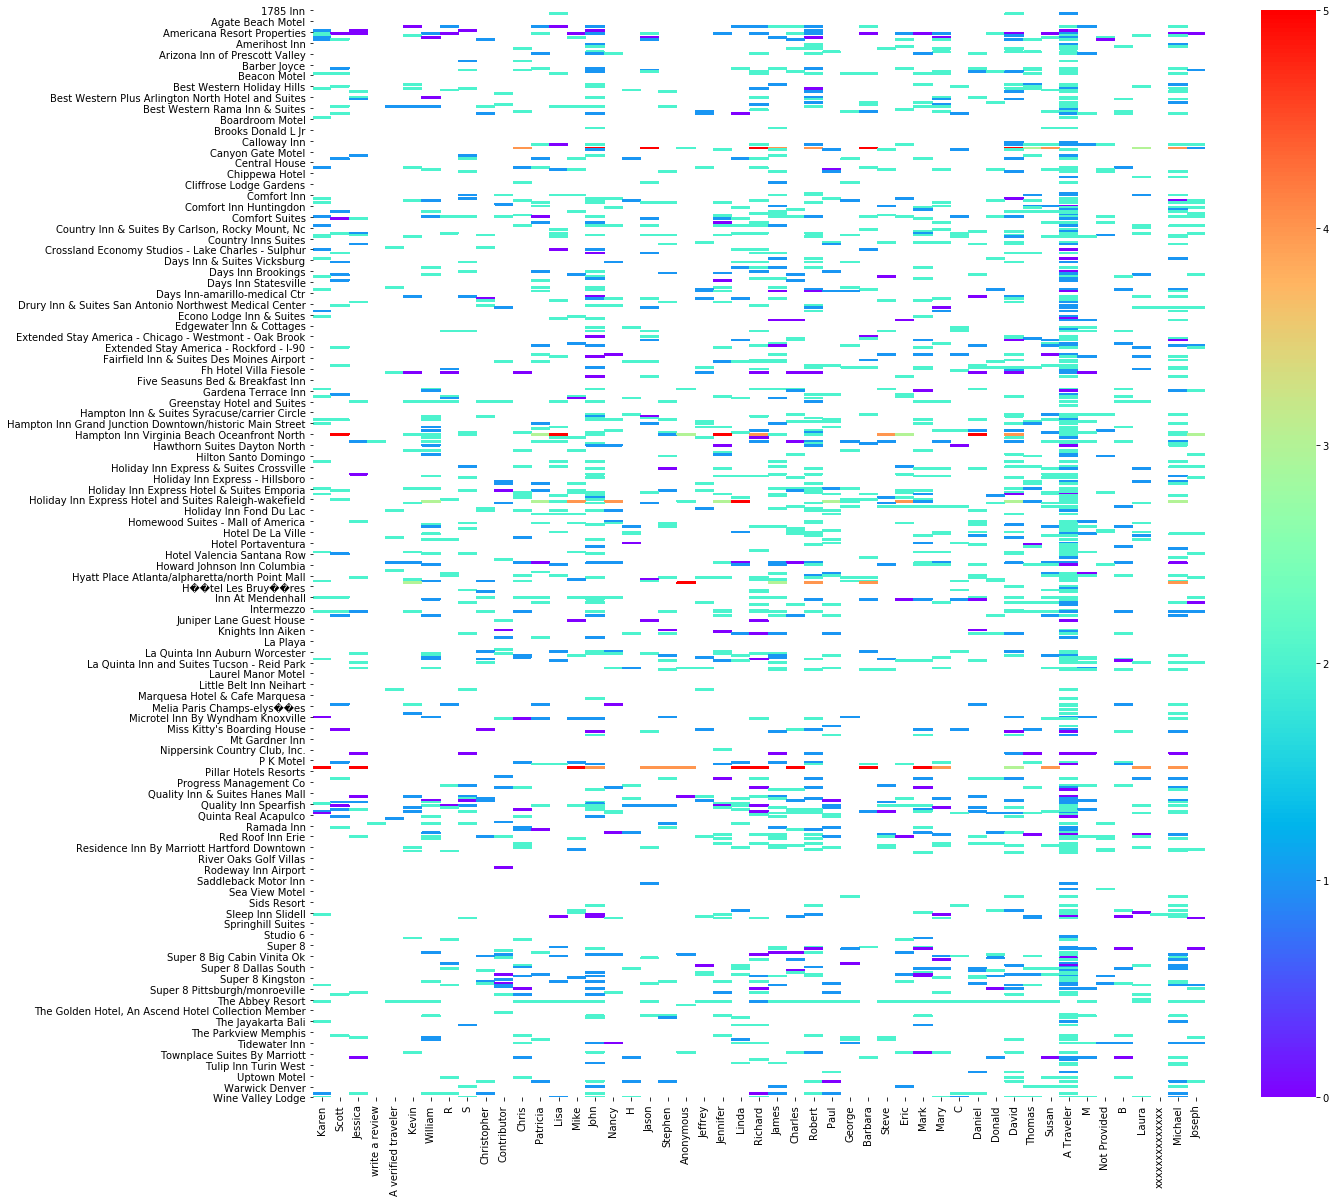

In [186]:
fig, ax = plt.subplots(figsize = (20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax = ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [187]:
hot_mat = np.array(df_hotels.fillna(-1).as_matrix())
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

C:\Users\zhuangchu\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [188]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [189]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [190]:
anno_hot.missing_values

[-1]

Look at coder agreement

In [191]:
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)#6 possible catagories

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


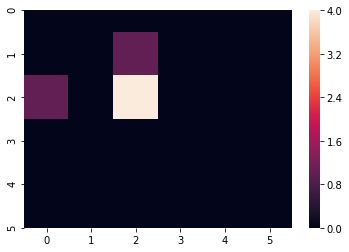

In [192]:
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6) #6 possible catagories
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [193]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [194]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [195]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

In [ ]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)

In [82]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

[0.7904694  0.73959802 0.76128702 0.72415501 0.71531648 0.71738583
 0.77232673 0.71548412]
-2725.647607136476


In [83]:
def makeQuestionComparison(model, anno_target, num_questions = 20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x13ffa1470>,
  <matplotlib.axes._subplots.AxesSubplot at 0x141492080>))

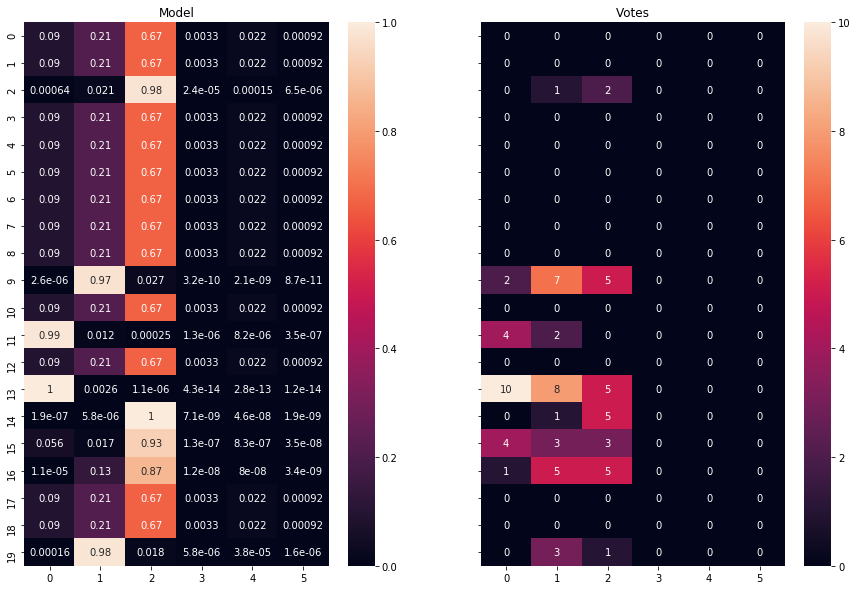

In [84]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

Continue the analysis in above section, I will further identify low-quality coders (suspected as No.1,5,6,7,12 from averaged across pair cohen's kappa) by using MAP to model all the coders' responses.

In [160]:
#For humanlikeness, create model B using MAP methods, with 5 label classes
model_human = ModelBt.create_initial_state(5, 13)
model_human.map(anno_human.annotations)
samples_human = model_human.sample_posterior_over_accuracy(anno_human.annotations, 200, burn_in_samples=100, thin_samples=3)

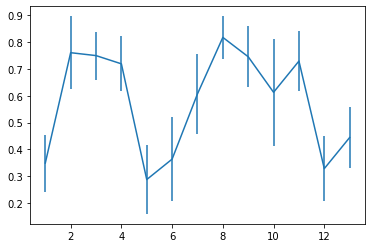

In [169]:
#plot the averaged accuracy across coders
y =  samples_human.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples_human.std(axis=0)#.mean(axis = 1).mean(axis = 1)
plt.figure()
plt.errorbar(range(1,14),y, yerr = y_ci)
plt.show()

From the two coder accuracy graphs, if we select accuracy rate of 0.5 as a chosen standard, coder No.1,5,6,12,13 (for humanlikeness), No.3,5,7,12,13 (for positiveness) are all susceptible of 'troll' behaviors, No.1,3,5,6,7,12,13, 7 low-quality coders in totals.

As I suspected in the section above, there is a high percentage of low-quality coders from MTurk and they heavily influence the reliability of the coding results. 

Another interesting finding is that, for positivity assessment, coders performed generally worse than humanlikeness assessment, which is against with my prediction. Assessing emotional dimension should be easier than assessing humanlikeness cognitively. However, the current analysis showed opposite results. One possible guess might be that the review contents usually cover both positive and negative comments on Alexa, which results in a puzzle situation for coders. Another guess is the order effect that 'humanlikeness' is always asked first, which might bias the results as well.

In [162]:
#For positiveness, create model B using MAP methods, with 5 label classes
model_pos = ModelBt.create_initial_state(5, 13)
model_pos.map(anno_pos.annotations)
samples_pos = model_pos.sample_posterior_over_accuracy(anno_pos.annotations, 200, burn_in_samples=100, thin_samples=3)

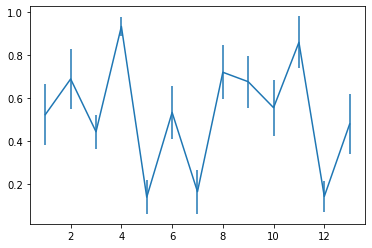

In [170]:
y =  samples_pos.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples_pos.std(axis=0)#.mean(axis = 1).mean(axis = 1)
plt.figure()
plt.errorbar(range(1,14),y, yerr = y_ci)
plt.show()

Using MAP model, further estimate the coding results, for both humanlikeness and postiveness:

In [175]:
#For humanlikeness, further predict true label classes by MAP model
posterior_human = model_human.infer_labels(anno_human.annotations)
print(model_human.theta)
print(model_human.log_likelihood(anno_human.annotations))

[0.28045108 0.83412906 0.70956331 0.70782781 0.15973257 0.29493596
 0.64488289 0.84903704 0.8069261  0.69425908 0.73590536 0.27849546
 0.559908  ]
-168.6219254396217


In [180]:
#For positiveness, further predict true label classes by MAP model
posterior_pos = model_pos.infer_labels(anno_pos.annotations)
print(model_pos.theta)
print(model_pos.log_likelihood(anno_pos.annotations))

[0.45770623 0.80538042 0.64342287 0.9997801  0.26288732 0.62556338
 0.13753131 0.71210032 0.76272351 0.7631814  0.99848806 0.11741259
 0.67476878]
-163.8191188817401


In [172]:
#For humanlikenss, plot heatmap graph based on the predicted answer 
votes = []
for r in anno_human.annotations:
    v = [0] * len(anno_human.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

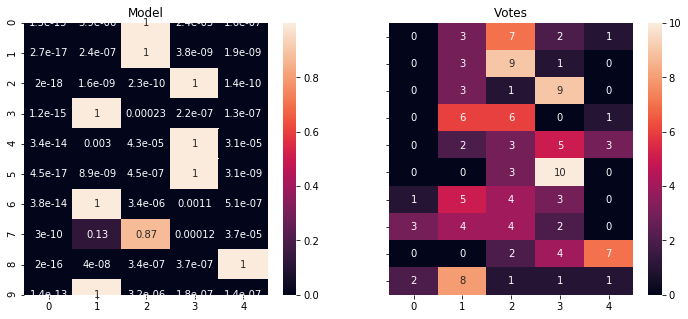

In [179]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12, 5), sharey=True)
num_questions = 10

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior_human[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

For humanlikenss, estimates from MAP model prediction is very consistent with the majority votes in the orginial data, and the probability score the model assigns to are also very high (near 1). An interesting finding is that, MAP model would seldom give extreme value (point 1 or 5) a guess, unless it is extremely biased towards it (for example the No.8 question).

In [181]:
#For positiveness, plot heatmap graph based on the predicted answer 
votes = []
for r in anno_pos.annotations:
    v = [0] * len(anno_pos.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)

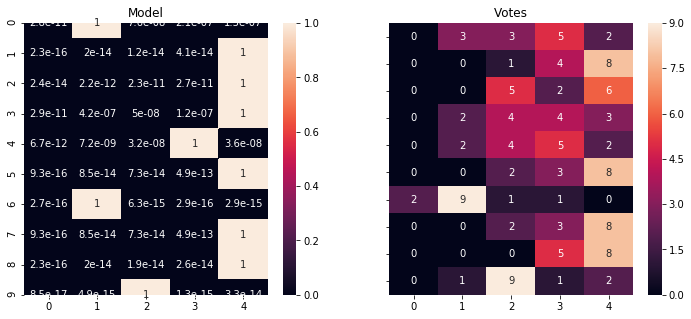

In [182]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12, 5), sharey=True)
num_questions = 10

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior_pos[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

However, for positiveness,estimates from MAP model prediction is slightly different from the majority votes (for example, No.1), which might come from the influence of low-quality coders. And the model is also very 'confident' for its prediction, all the max probability assigned is near to one. But I am wondering what might influence its 'confidency', might it still be the case, if there are more sample questions or coders, or more low-quality coders. 